In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from glob import glob
from IPython.display import HTML
# %matplotlib notebook

### Utility Functions

In [2]:
def draw_flow(image, U, V, stride=10):
    for i in range(0,image.shape[0],stride):
        for j in range(0, image.shape[1],stride):
            im_copy = cv2.circle(image, (j,i), 1, (255,0,0), 1)
            x  = (j,i)
            xs = (int(np.round(j+U[i,j])),int(np.round(i+V[i,j])))
            im_copy = cv2.arrowedLine(image, x, xs, (0,0,255), 1)
    plt.imshow(im_copy)
    plt.show()

In [3]:
def save_feature_tracking(name, image, optical_flow):
    for feature in optical_flow:
        feature = np.array(feature, np.int32).reshape((-1,1,2))
        cv2.polylines(image, [feature], False, (0,255,255),4)
    plt.imsave(name, image)

### Functions to Compute Spatio-Temporal Gradient of consecutive image frames

In [4]:
def get_x_gradient(image1, image2):
    kernel = np.array([
        [-1,  1],
        [-1,  1],
    ])
    x_grad_image = (cv2.filter2D(image1, -1, kernel) + cv2.filter2D(image2, -1, kernel))#/2
    return x_grad_image

In [5]:
def get_y_gradient(image1, image2):
    kernel = np.array([
        [-1, -1],
        [ 1,  1],
    ])
    y_grad_image = (cv2.filter2D(image1, -1, kernel) + cv2.filter2D(image2, -1, kernel))#/2
    return y_grad_image

In [6]:
def get_time_gradient(image1, image2):
    kernel1 = np.array([
        [-1, -1],
        [-1, -1],
    ])
    kernel2 = np.array([
        [ 1,  1],
        [ 1,  1],
    ])
    
    t_grad_image = cv2.filter2D(image1, -1, kernel1) + cv2.filter2D(image2, -1, kernel2)
    return t_grad_image

In [7]:
def compute_gradients(image1, image2):
    Ix = get_x_gradient(image1, image2)
    Iy = get_y_gradient(image1, image2)
    It = get_time_gradient(image1, image2)
    return Ix, Iy, It

## Computing Optical Flow

To compute the Optical Flow using the Lucas Kanade Method, we make the following assumptions,
- Brightness Constancy Assumption 
    - $f(x,y,t) = f(x+dx, y+dy, t+dt)$
- Optical Flow Constraint
    - Using Taylor Series Approximation, we get,
    - $f_{x}u + f_{y}v + f_{t} = 0$
    - This gives us an equation of a straight line. 
    - One equation with two unknowns, this is an under constrained problem.
- Spatial Coherence Constraint
    - Assume the pixels in a neighbourhood have the same u, and v.
    - So essentially we get a $s^{2}$ equations for a window of length and width $s$.
    - Therefore, under this assumption, we can compute the optical flow.

Therefore for computing the Optical Flow, we have the following steps,
- Optical Flow Equation
    - $f_{x}u + f_{y}v + f_{t} = 0$
- Consider a window around a pixel, lets say of size 3 x 3. This gives us 9 equations, assuming the constraints mentioned above,
    - $f_{x1}u + f_{y1}v + f_{t1} = 0$ --- $f_{x9}u + f_{y9}v + f_{t9} = 0$
- We can rewrite the equations in the matrix form as
    - $Au = f_{t}$
- We solve the above by solving the Least Square Fit problem
    - $u = (A^{T}A)^{-1}A^{T}f_{t}$
    - The $u$ vector gives us the x and y velocity, hence giving the optical flow

In [8]:
def compute_optical_flow(image1, image2, window_size):
    image1 = cv2.GaussianBlur(image1, (3,3), 0)
    image2 = cv2.GaussianBlur(image2, (3,3), 0)
    Ix, Iy, It = compute_gradients(image1, image2)
    window_sum = np.zeros(Ix.shape)
    U = np.zeros(Ix.shape)
    V = np.zeros(Ix.shape)
    stride = window_size//2
    for i in range(stride, Ix.shape[0]-stride):
        for j in range(stride, Ix.shape[1]-stride):
            ix = Ix[i-stride:i+stride+1, j-stride:j+stride+1].reshape((window_size**2,1))
            iy = Iy[i-stride:i+stride+1, j-stride:j+stride+1].reshape((window_size**2,1))
            it = -1 * It[i-stride:i+stride+1, j-stride:j+stride+1].reshape((window_size**2,1))
            
            A = np.hstack((ix, iy))
            u = np.linalg.pinv(A.T @ A) @ A.T @ it
            
            U[i,j] = u[0]
            V[i,j] = u[1]
            
    return U,V

### Function to compute the Motion Segmentation
- We can obtain the motion segmentation from the optical flow vectors
- We do this be computing the magnitude and angle of the velocity vector of each of the pixel and thresholding by a minimum displacement
- We convert these maginitudes and angles into an HSV representation in order to encode the angle and intensity for each pixel
- This clusters pixels moving in the same direction and gives us the object segmentation mask

In [9]:
def get_motion_segmentation(U_orig, V_orig, threshold=0.8):
    U = dc(U_orig)
    V = dc(V_orig)
    U[np.abs(U)<threshold] = 0
    V[np.abs(V)<threshold] = 0
    magnitude, angle = cv2.cartToPolar(U, V)
    hue        = 2*angle*180/3.14
    saturation = np.ones(U.shape)*255 
    value      = magnitude*255
    segmented_mask = np.dstack((hue, saturation))
    segmented_mask = np.dstack((segmented_mask, value)).astype('uint8')
    segmented_mask = cv2.cvtColor(segmented_mask, cv2.COLOR_HSV2RGB)
    plt.imshow(segmented_mask)
    plt.show()

### Function to track features
- We extract good feature points per image and track their position using the optical flow vectors for that feature point

In [10]:
def track_features(images, output_dir, window_size=31, num_features=35, threshold=0.8):
    frame1 = cv2.imread(images[0], 0)
    features = cv2.goodFeaturesToTrack(frame1,num_features,0.01,10)
    frame1=frame1/255.0
    optical_flow = [[(i.ravel()[0], i.ravel()[1])] for i in features]

    for i in range(1, len(images)):
        print(i)
        frame2 = cv2.imread(images[i], 0)/255.0
        U, V = compute_optical_flow(frame1, frame2, window_size)
        U[np.abs(U)<threshold] = 0
        V[np.abs(V)<threshold] = 0
        for feat in optical_flow:
            last_entry = feat[-1]
            k = np.sum(np.sum(U[int(last_entry[1])-window_size:int(last_entry[1])+window_size,int(last_entry[0])-window_size:int(last_entry[0])+window_size]))//(window_size**2)
            l = np.sum(np.sum(V[int(last_entry[1])-window_size:int(last_entry[1])+window_size,int(last_entry[0])-window_size:int(last_entry[0])+window_size]))//(window_size**2)
            a = last_entry[0] + int(k)
            b = last_entry[1] + int(l)
            feat.append((a,b))
            
        frame_save = cv2.imread(images[i-1])
        save_feature_tracking(output_dir+'{}.jpg'.format(i), frame_save, optical_flow)
        frame1 = frame2
    return optical_flow

### Function to track objects
- We approximate the objects motion by computing the average velocity of all the pixels bounded by the object and try to localize the position of the object using the average velocity

In [11]:
def track_objects(images, output_dir, bbox, window_size=31, threshold=0.8):
    frame1 = cv2.imread(images[0], 0)/255.0
    for i in range(1, len(images)):
        print(i)
        frame2 = cv2.imread(images[i], 0)/255.0
        U, V = compute_optical_flow(frame1, frame2, window_size)
        U[np.abs(U)<threshold] = 0
        V[np.abs(V)<threshold] = 0

        num_pixel = ((bbox[3]-bbox[1])*(bbox[2]-bbox[0]))
        u = np.sum(np.sum(U[bbox[1]:bbox[3], bbox[0]:bbox[2]]))/num_pixel
        v = np.sum(np.sum(V[bbox[1]:bbox[3], bbox[0]:bbox[2]]))/num_pixel
        bbox[0] = int(np.ceil(bbox[0] + u))
        bbox[1] = int(np.ceil(bbox[1] + v))
        bbox[2] = int(np.ceil(bbox[2] + u))
        bbox[3] = int(np.ceil(bbox[3] + v))
        
        frame_save = cv2.imread(images[i-1])
        cv2.rectangle(frame_save, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
        
        plt.imsave(output_dir+'{}.jpg'.format(i), frame_save)
        frame1 = frame2

In [12]:
def task1(path1, path2):
    image1 = cv2.imread(path1,0)/255.0
    image2 = cv2.imread(path2,0)/255.0
    U,V = compute_optical_flow(image1, image2, window_size=31)
    result = cv2.imread(path1)
    draw_flow(result, U, V, stride=5)
    flow = np.zeros(result.shape) + 255
    draw_flow(flow, U, V, stride=5)
    get_motion_segmentation(U,V,threshold=0.8)

In [13]:
def task2(input_dir, frames):
    images = sorted(glob('./{}/*'.format(input_dir)))
    images = images[frames[0]:frames[1]]
    optical_flow = track_features(images, './output/{}/'.format(input_dir))

In [14]:
def task3(input_dir, frames, bbox):
    images = sorted(glob('./{}/*'.format(input_dir)))
    images = images[frames[0]:frames[1]]
    track_objects(images, './object_output/{}/'.format(input_dir), bbox)

## Results and Outputs

### Flow Maps, Optical Flow and Motion Segmentation
- The results of the output heavily depend on the window size considered.
- When the window size id too small then the flow is not captured correctly.
- The window size of 31 was found to work the best emperically, as it is able to capture the small motion correctly.

BasketBall


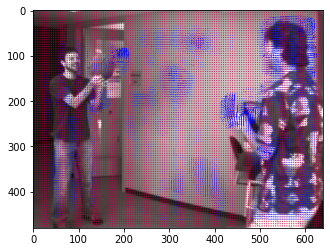

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


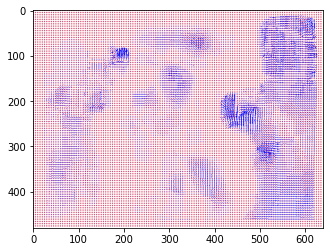

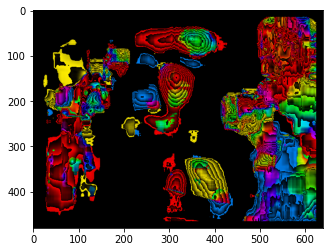

Army


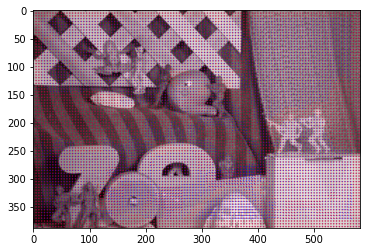

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


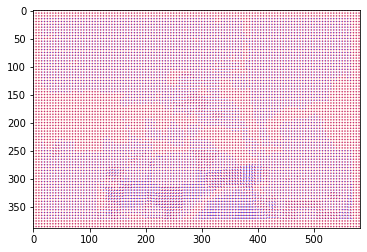

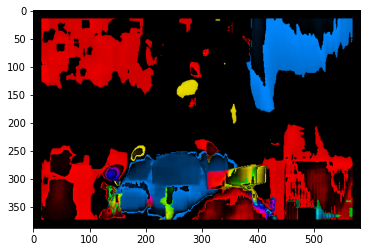

Backyard


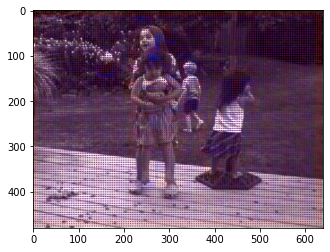

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


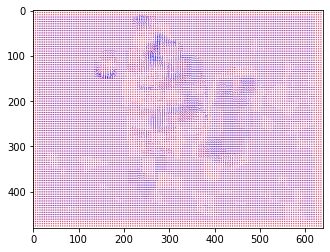

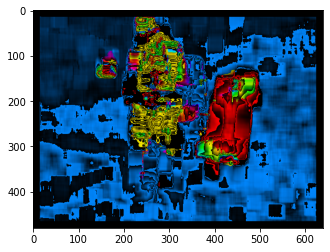

Dumptruck


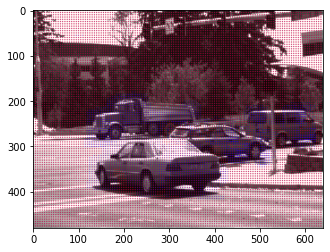

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


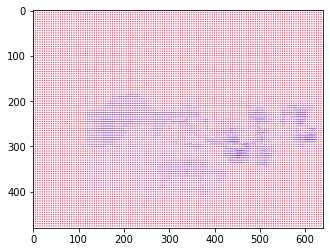

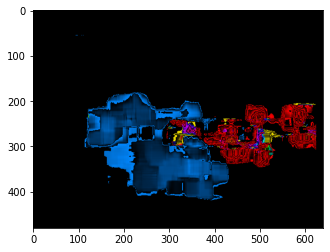

Yosemite


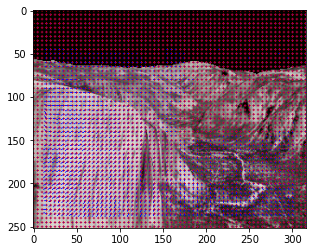

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


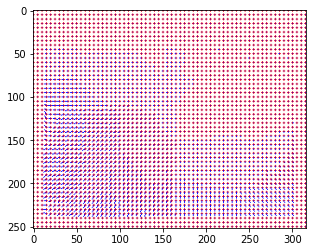

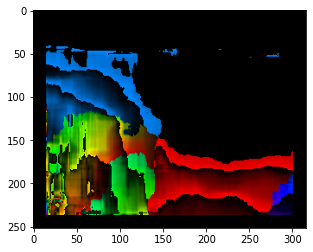

Grove


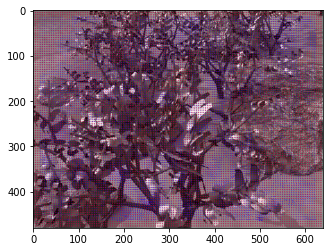

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


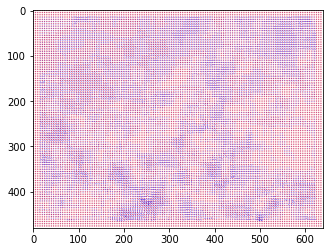

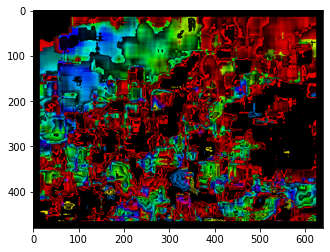

In [15]:
print("BasketBall")
task1(path1='./data/Basketball/frame10.png', path2='./data/Basketball/frame11.png')
print("Army")
task1(path1='./data/Army/frame10.png', path2='./data/Army/frame11.png')
print("Backyard")
task1(path1='./data/Backyard/frame10.png', path2='./data/Backyard/frame11.png')
print("Dumptruck")
task1(path1='./data/Dumptruck/frame10.png', path2='./data/Dumptruck/frame11.png')
print("Yosemite")
task1(path1='./data/Yosemite/frame10.png', path2='./data/Yosemite/frame11.png')
print("Grove")
task1(path1='./data/Grove/frame10.png', path2='./data/Grove/frame11.png')

### Feature Tracking
- As it can be seen from the results, the feature points are tracked almost correctly. We can improve the results be applying more filtering on the results.

In [16]:
HTML('<img src="./feature_tracking_outputs/feat_track_1.gif" height="400" width="400">')

In [17]:
HTML('<img src="./feature_tracking_outputs/feat_track_2.gif" height="400" width="400">')

In [18]:
HTML('<img src="./feature_tracking_outputs/feat_track_3.gif" height="400" width="400">')

In [19]:
HTML('<img src="./feature_tracking_outputs/feat_track_4.gif" height="400" width="400">')

### Object Tracking
- As it can be seen from the results, the apparent motion of the object as a whole not approximated correctly by taking the average motion of the bounded pixels.

In [20]:
HTML('<img src="./object_tracking_outputs/obj_track_2.gif" height="400" width="400">')

In [21]:
HTML('<img src="./object_tracking_outputs/obj_track_1.gif" height="400" width="400">')